## Visualize Results: Maps

In [65]:
# import libraries
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, TwoSlopeNorm
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as mticker
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import xarray as xr
import os
import numpy as np

In [66]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [67]:
# load country borders
countries_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
countries = gpd.read_file(countries_path)

# get german border
ger_border = countries[countries['NAME'] == 'Germany'].to_crs(epsg = 32632)

# load state borders
states_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(states_path)

# get german federal states
ger_states = states[states['admin'] == 'Germany'].to_crs(epsg = 32632)

### Forest Area 2022

In [4]:
lccs = xr.open_dataset("./Forest_GER/Forest_GER_2022.nc")

In [5]:
lccs_data = lccs.variables["lccs_class"].values
lats = lccs.variables['lat'].values
lons = lccs.variables['lon'].values

In [6]:
# create new array to plot forest data
# start with array filled with nans
forest = np.full(lccs_data.shape, np.nan, dtype=float)

# set all pixels with BL forest to 1
forest[lccs_data == 60] = 1

# set all pixels with NL forest to 2
forest[(lccs_data == 70) | (lccs_data == 80)] = 2

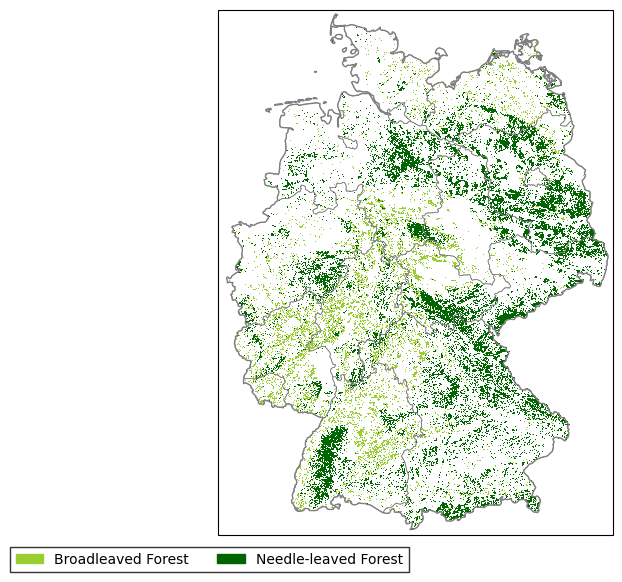

In [7]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# set colors
colors = ['yellowgreen', 'darkgreen']
cmap_custom = ListedColormap(colors)

# set boundaries for colormap to map different forest classes
bounds = [0.5, 1.5, 2.5]
norm_custom = BoundaryNorm(bounds, cmap_custom.N)

# set nan values as transparent
cmap_custom.set_bad(alpha=0)

# create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6.325), subplot_kw={'projection': projUTM})
ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)
ax.set_aspect('equal', adjustable='box')

# plot data
im = ax.pcolormesh(
    lons, 
    lats, 
    forest.squeeze(), 
    cmap=cmap_custom,
    norm=norm_custom,
    transform=projPC,
    shading = "auto" 
)

# plot borders
ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

# create 'patch' objects that will serve as legend handles
bl_patch = mpatches.Patch(color=colors[0], label=f'Broadleaved Forest')
nl_patch = mpatches.Patch(color=colors[1], label=f'Needle-leaved Forest')

# add the legend to the plot
ax.legend(
    handles=[bl_patch, nl_patch],
    loc='upper right',         
    bbox_to_anchor=(0.5, -0.01), 
    ncol=2,                      
    fontsize=10,
    frameon=True,              
    fancybox=False,              
    facecolor='white',          
    edgecolor='black'    
)

plt.subplots_adjust(bottom=0.05)
plt.savefig("./Figures/Forest_Area_Map.png", bbox_inches="tight")
plt.show() 

### NDVI Trend

In [8]:
ndvi_BL = xr.open_dataset("./Spatial_Trends/NDVI_Spatial_Trend_BL.nc")
ndvi_NL = xr.open_dataset("./Spatial_Trends/NDVI_Spatial_Trend_NL.nc")

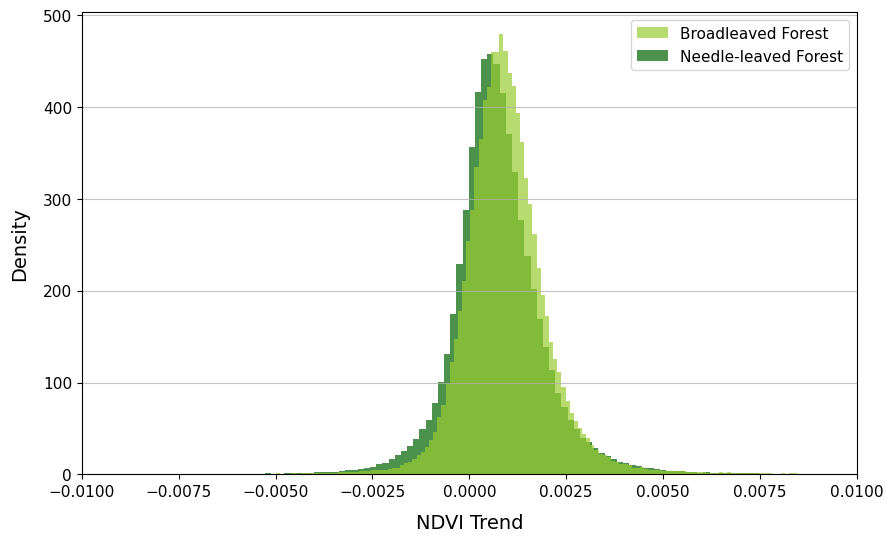

In [9]:
# plot histograms to look at distribution of values

BL_vals = ndvi_BL.variables['NDVI'][:,:].values
NL_vals = ndvi_NL.variables['NDVI'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('NDVI Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.01, 0.01) 

plt.savefig("./Figures/NDVI_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [10]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.0016641974844710773
Calculated 98th Percentile: 0.00375403058002421


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\1902628475.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


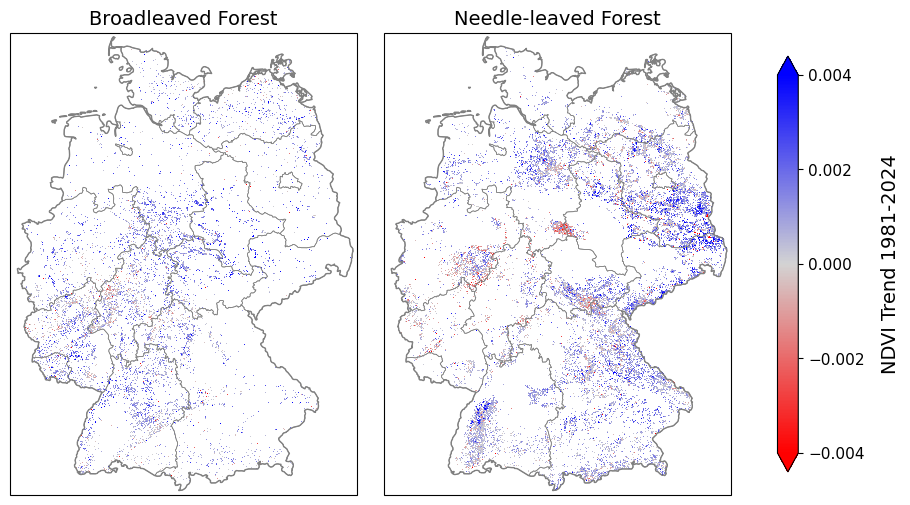

In [11]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = ndvi_BL.variables['NDVI'][:,:]
NL = ndvi_NL.variables['NDVI'][:,:]
lats = ndvi_BL.variables['lat'][:]
lons = ndvi_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.004
vmax = 0.004

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NDVI Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/NDVI_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### LAI Trend

In [12]:
lai_BL = xr.open_dataset("./Spatial_Trends/LAI_Spatial_Trend_BL.nc")
lai_NL = xr.open_dataset("./Spatial_Trends/LAI_Spatial_Trend_NL.nc")

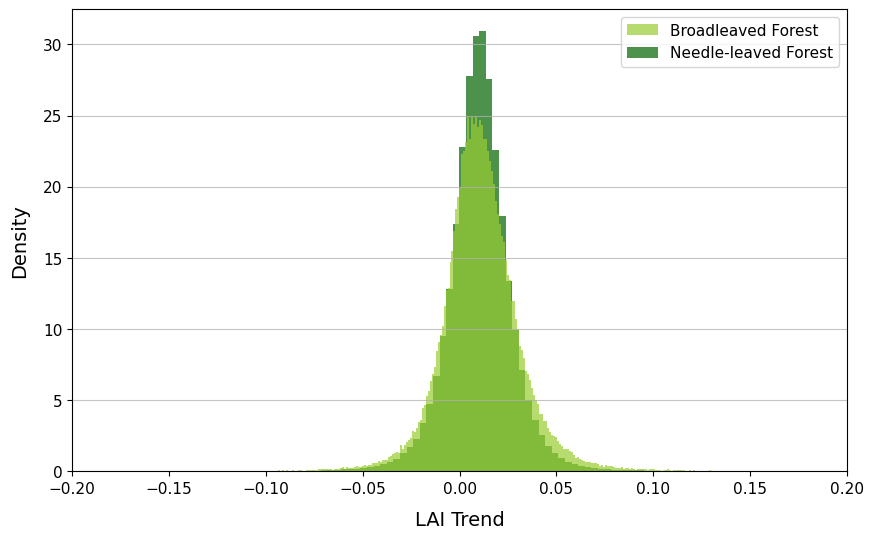

In [13]:
# plot histograms to look at distribution of values

BL_vals = lai_BL.variables['LAI'][:,:].values
NL_vals = lai_NL.variables['LAI'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=50000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=50000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('LAI Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.2, 0.2) 

plt.savefig("./Figures/LAI_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [14]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.0288943901270265
Calculated 98th Percentile: 0.05191609631382816


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\1163758565.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


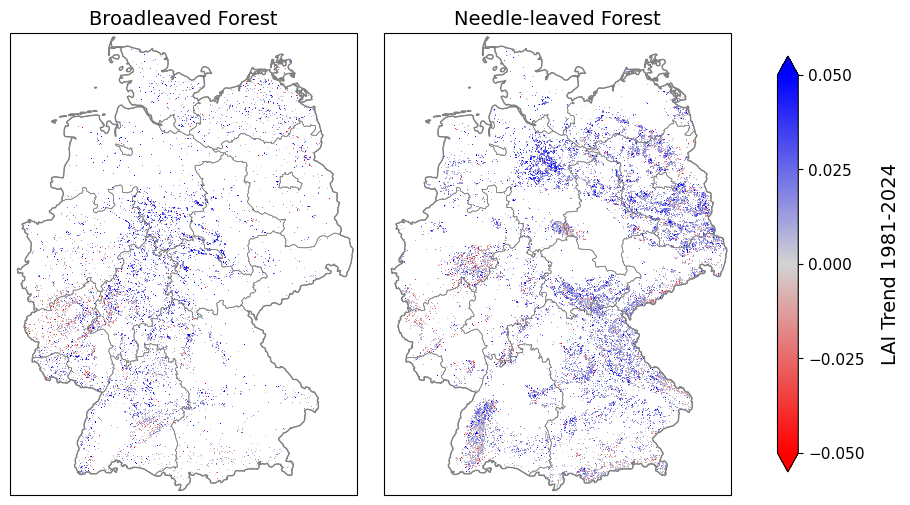

In [15]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = lai_BL.variables['LAI'][:,:]
NL = lai_NL.variables['LAI'][:,:]
lats = lai_BL.variables['lat'][:]
lons = lai_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.05
vmax = 0.05

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("LAI Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/LAI_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### FAPAR Trend

In [16]:
fapar_BL = xr.open_dataset("./Spatial_Trends/FAPAR_Spatial_Trend_BL.nc")
fapar_NL = xr.open_dataset("./Spatial_Trends/FAPAR_Spatial_Trend_NL.nc")

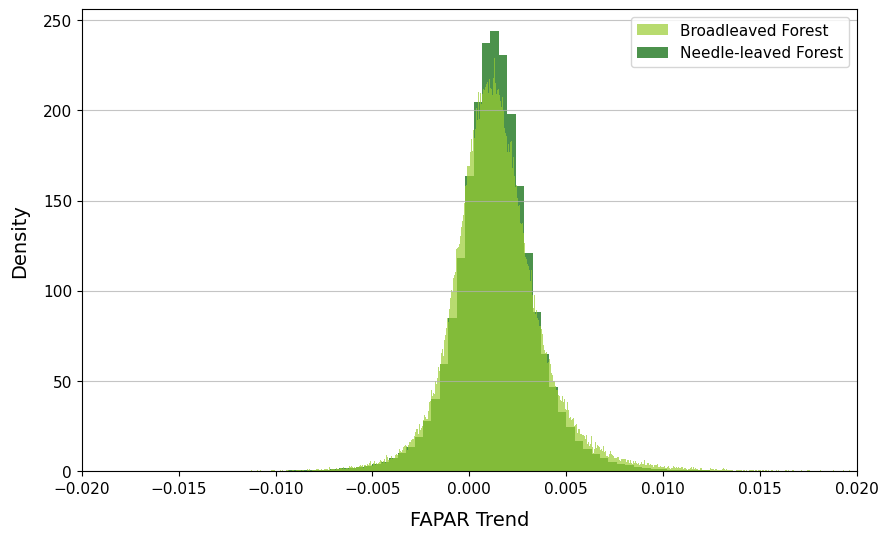

In [17]:
# plot histograms to look at distribution of values

BL_vals = fapar_BL.variables['FAPAR'][:,:].values
NL_vals = fapar_NL.variables['FAPAR'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('FAPAR Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.02, 0.02) 

plt.savefig("./Figures/FAPAR_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [18]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.0033076273091026836
Calculated 98th Percentile: 0.006814156283500741


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\3869197929.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


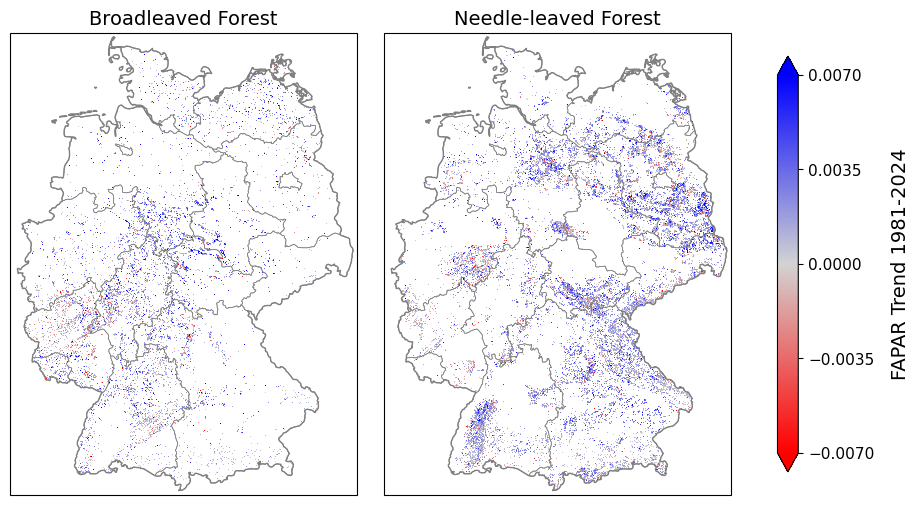

In [19]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = fapar_BL.variables['FAPAR'][:,:]
NL = fapar_NL.variables['FAPAR'][:,:]
lats = fapar_BL.variables['lat'][:]
lons = fapar_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.007
vmax = 0.007

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("FAPAR Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/FAPAR_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Air Temperature Trend

In [20]:
t2m_BL = xr.open_dataset("./Spatial_Trends/t2m_Spatial_Trend_BL.nc")
t2m_NL = xr.open_dataset("./Spatial_Trends/t2m_Spatial_Trend_NL.nc")

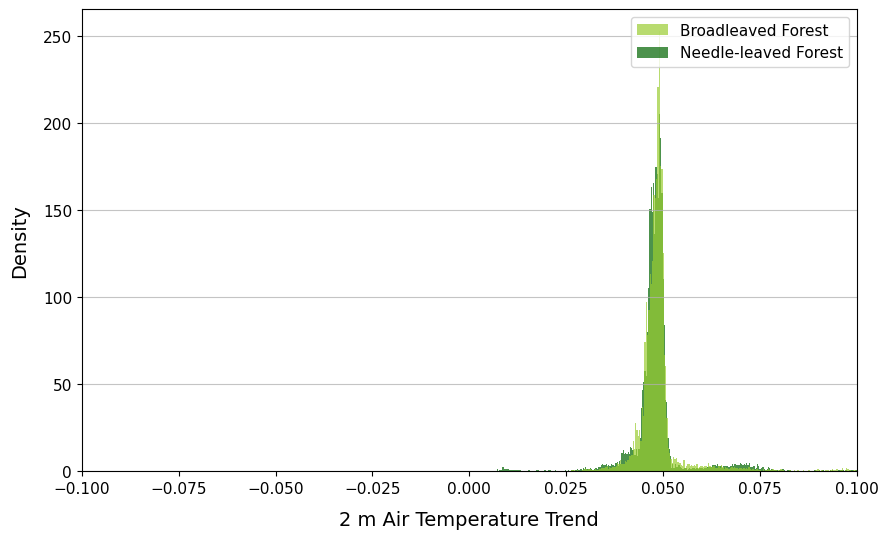

In [21]:
# plot histograms to look at distribution of values

BL_vals = t2m_BL.variables['t2m'][:,:].values
NL_vals = t2m_NL.variables['t2m'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('2 m Air Temperature Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.1, 0.1) 

plt.savefig("./Figures/Temperature_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [22]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: 0.03398940979019708
Calculated 98th Percentile: 0.09606062291742415


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\807281726.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


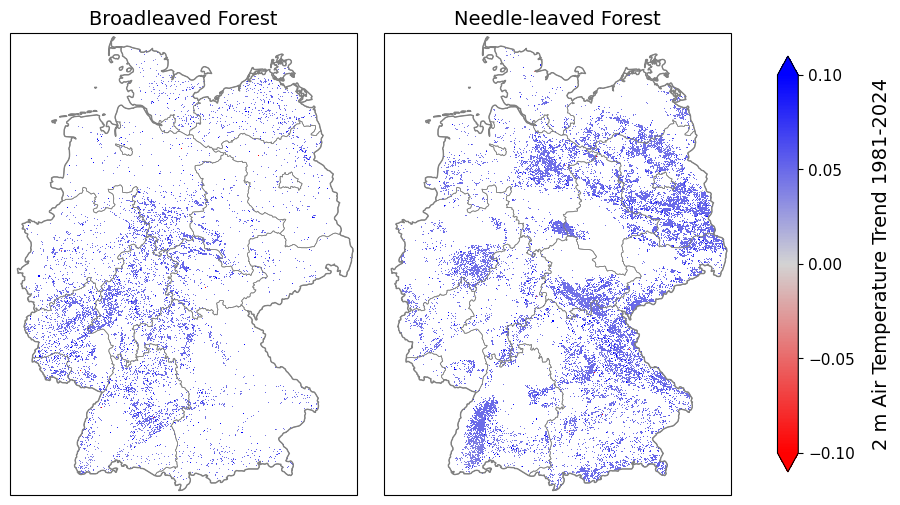

In [23]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = t2m_BL.variables['t2m'][:,:]
NL = t2m_NL.variables['t2m'][:,:]
lats = t2m_BL.variables['lat'][:]
lons = t2m_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.1
vmax = 0.1

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("2 m Air Temperature Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Temperature_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Precipitation Trend Germany

In [24]:
tp = xr.open_dataset("./Spatial_Trends/tp_Spatial_Trend_GER.nc")

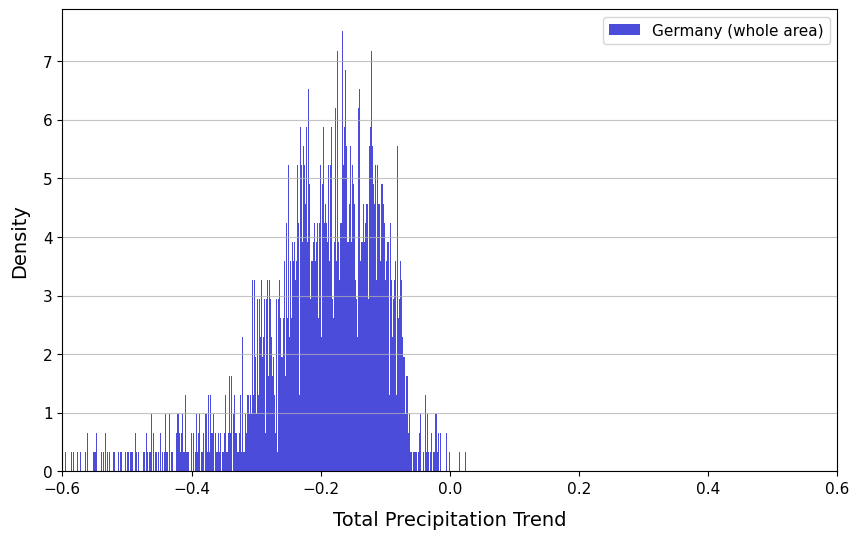

In [25]:
# plot histogram to look at distribution of values

tp_vals = tp.variables['tp'][:,:].values

plt.figure(figsize=(10, 6))

plt.hist(tp_vals.flatten(), bins=1000, alpha=0.7, label='Germany (whole area)', color='mediumblue', density=True) 

# add labels
plt.xlabel('Total Precipitation Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

plt.legend(loc = 1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.6, 0.6) 

plt.savefig("./Figures/Precipitation_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [26]:
# have a look at the percentiles
data = tp_vals.flatten()

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(data[~np.isnan(data)], lower_percentile)
vmax_perc = np.percentile(data[~np.isnan(data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.49192326170718237
Calculated 98th Percentile: -0.05580413085757584


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\381143425.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


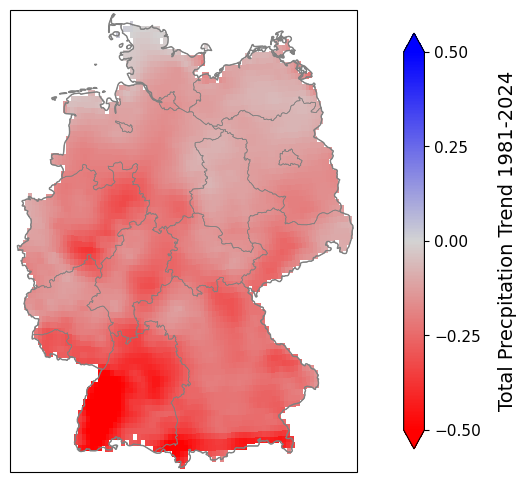

In [27]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variable from xarray
tp_var = tp.variables['tp'][:,:]
lats = tp.variables['lat'][:]
lons = tp.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.5
vmax = 0.5

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})

ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

# plot data
im = ax.pcolormesh(
        lons, lats, tp_var,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto")

# plot borders
ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Total Precpitation Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Precipitation_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Wind Speed Trend

In [28]:
wind10m_BL = xr.open_dataset("./Spatial_Trends/wind10m_Spatial_Trend_BL.nc")
wind10m_NL = xr.open_dataset("./Spatial_Trends/wind10m_Spatial_Trend_NL.nc")

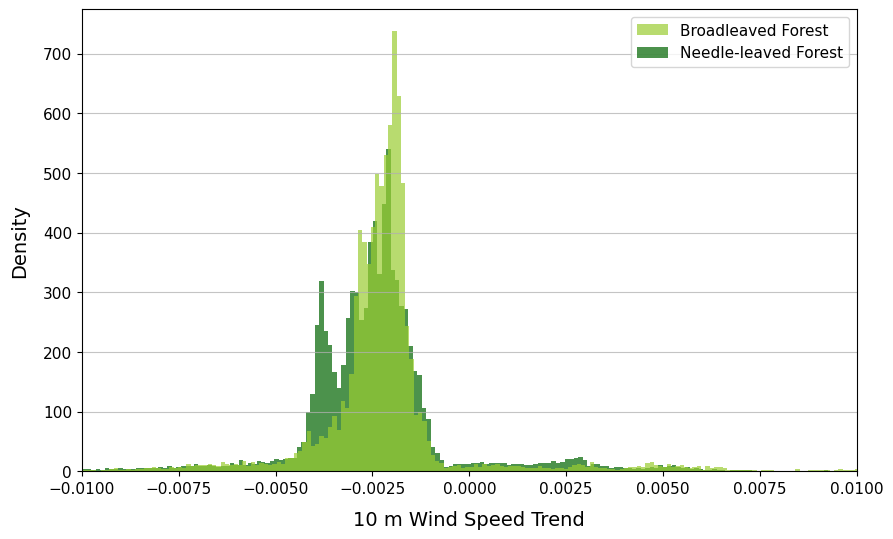

In [29]:
# plot histograms to look at distribution of values

BL_vals = wind10m_BL.variables['wind10m'][:,:].values
NL_vals = wind10m_NL.variables['wind10m'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('10 m Wind Speed Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.01, 0.01) 

plt.savefig("./Figures/Windspeed_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [30]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.00755571558944179
Calculated 98th Percentile: 0.008665858305894336


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\3109297047.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


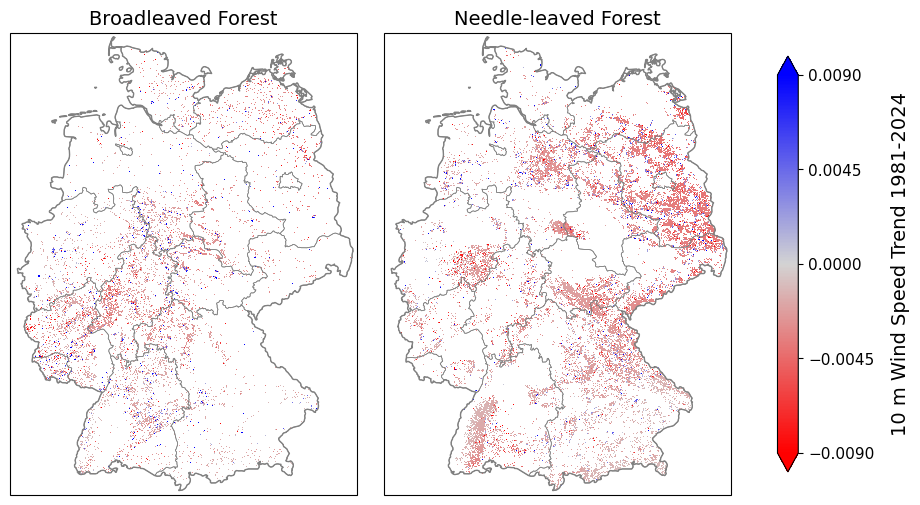

In [31]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = wind10m_BL.variables['wind10m'][:,:]
NL = wind10m_NL.variables['wind10m'][:,:]
lats = wind10m_BL.variables['lat'][:]
lons = wind10m_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.009
vmax = 0.009

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("10 m Wind Speed Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Windspeed_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Soil Moisture Layer 1 Trend

In [32]:
swvl1_BL = xr.open_dataset("./Spatial_Trends/swvl1_Spatial_Trend_BL.nc")
swvl1_NL = xr.open_dataset("./Spatial_Trends/swvl1_Spatial_Trend_NL.nc")

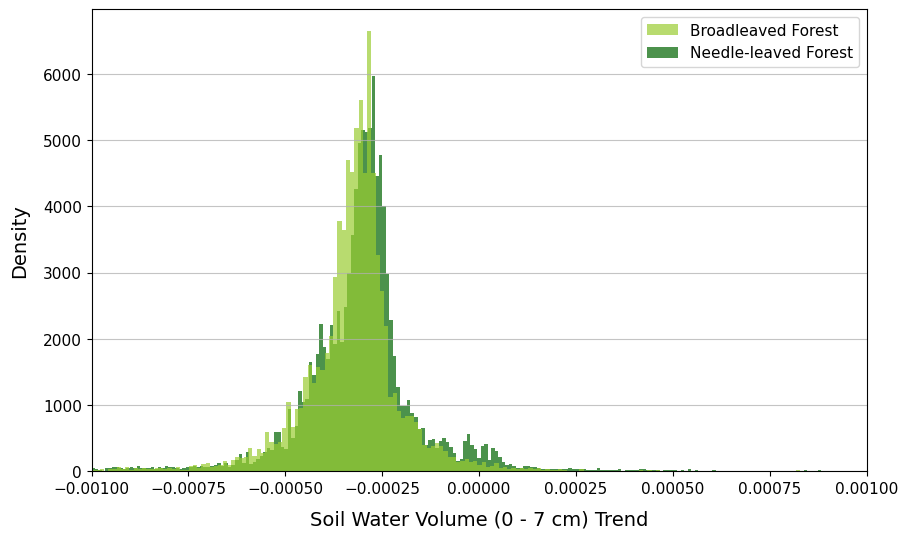

In [33]:
# plot histograms to look at distribution of values

BL_vals = swvl1_BL.variables['swvl1'][:,:].values
NL_vals = swvl1_NL.variables['swvl1'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Water Volume (0 - 7 cm) Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_1_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [34]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.0007914635201392978
Calculated 98th Percentile: 0.00018005871557371454


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\4235825409.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


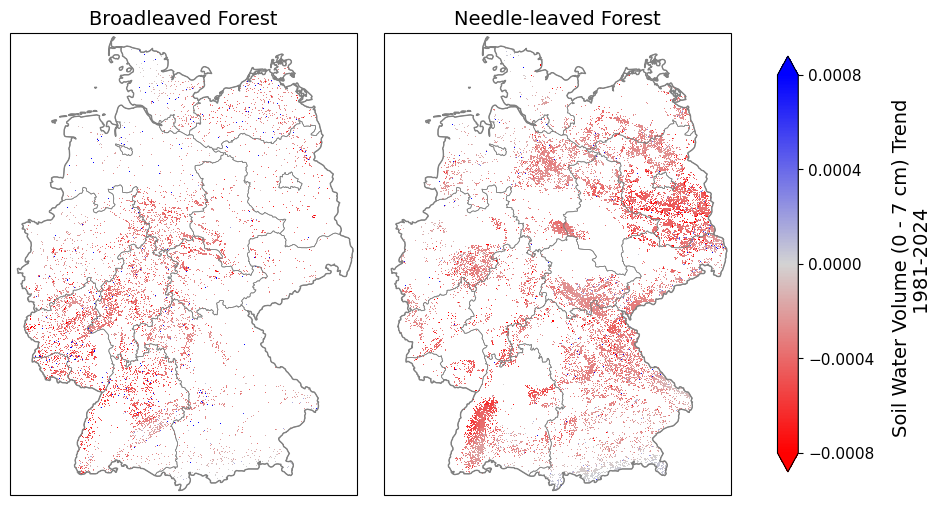

In [61]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl1_BL.variables['swvl1'][:,:]
NL = swvl1_NL.variables['swvl1'][:,:]
lats = swvl1_BL.variables['lat'][:]
lons = swvl1_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0008
vmax = 0.0008

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil Water Volume (0 - 7 cm) Trend \n 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_1_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Soil Moisture Layer 2 Trend

In [36]:
swvl2_BL = xr.open_dataset("./Spatial_Trends/swvl2_Spatial_Trend_BL.nc")
swvl2_NL = xr.open_dataset("./Spatial_Trends/swvl2_Spatial_Trend_NL.nc")

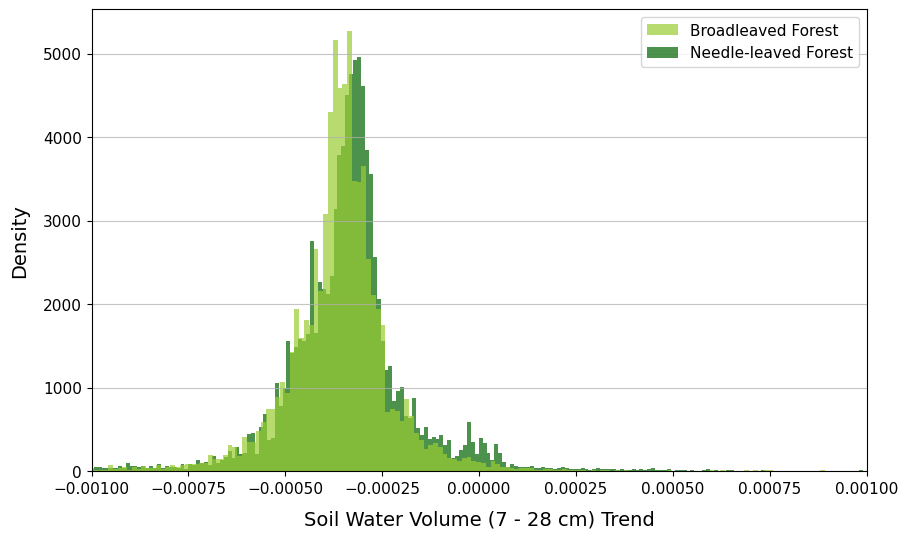

In [37]:
# plot histograms to look at distribution of values

BL_vals = swvl2_BL.variables['swvl2'][:,:].values
NL_vals = swvl2_NL.variables['swvl2'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Water Volume (7 - 28 cm) Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10)

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_2_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [38]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.0008647274207598984
Calculated 98th Percentile: 0.00021508479347602367


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\1251456414.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


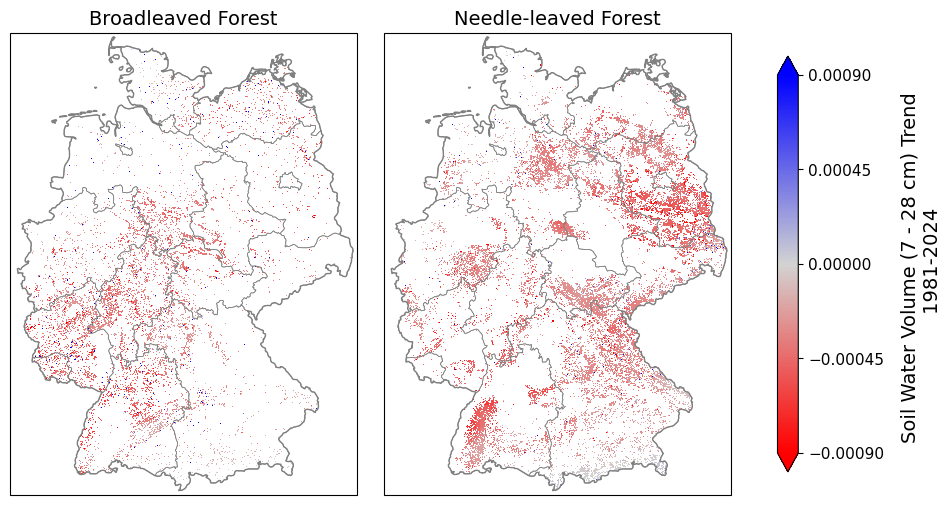

In [62]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl2_BL.variables['swvl2'][:,:]
NL = swvl2_NL.variables['swvl2'][:,:]
lats = swvl2_BL.variables['lat'][:]
lons = swvl2_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0009
vmax = 0.0009

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil Water Volume (7 - 28 cm) Trend \n 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_2_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Soil Moisture Layer 3 Trend

In [68]:
swvl3_BL = xr.open_dataset("./Spatial_Trends/swvl3_Spatial_Trend_BL.nc")
swvl3_NL = xr.open_dataset("./Spatial_Trends/swvl3_Spatial_Trend_NL.nc")

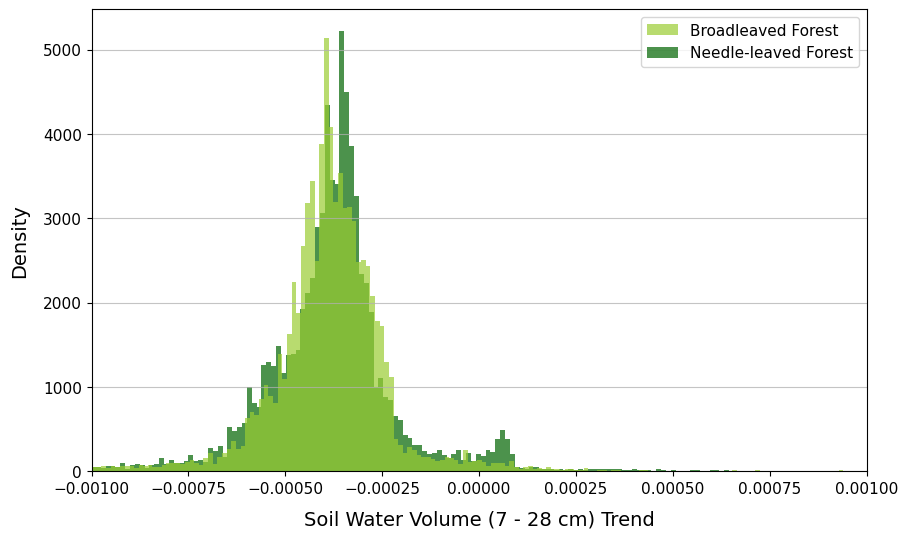

In [69]:
# plot histograms to look at distribution of values

BL_vals = swvl3_BL.variables['swvl3'][:,:].values
NL_vals = swvl3_NL.variables['swvl3'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Water Volume (28 - 100 cm) Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# add labels
plt.xlabel('Soil Water Volume (7 - 28 cm) Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_3_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [42]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc}")
print(f"Calculated 98th Percentile: {vmax_perc}")

Calculated 2nd Percentile: -0.0010829780782971525
Calculated 98th Percentile: 0.000189201347845494


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\3777785576.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


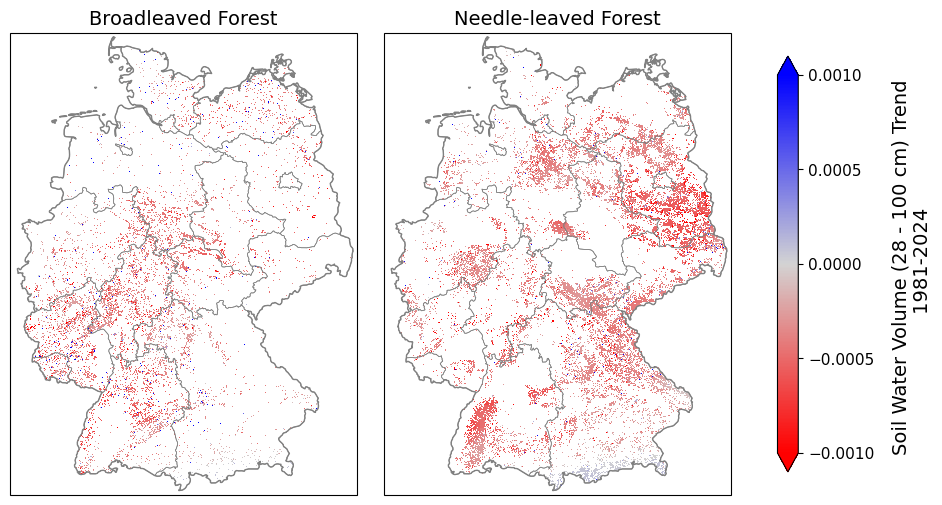

In [63]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl3_BL.variables['swvl3'][:,:]
NL = swvl3_NL.variables['swvl3'][:,:]
lats = swvl3_BL.variables['lat'][:]
lons = swvl3_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.001
vmax = 0.001

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil Water Volume (28 - 100 cm) Trend \n 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_3_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### Soil Moisture Layer 4 Trend

In [44]:
swvl4_BL = xr.open_dataset("./Spatial_Trends/swvl4_Spatial_Trend_BL.nc")
swvl4_NL = xr.open_dataset("./Spatial_Trends/swvl4_Spatial_Trend_NL.nc")

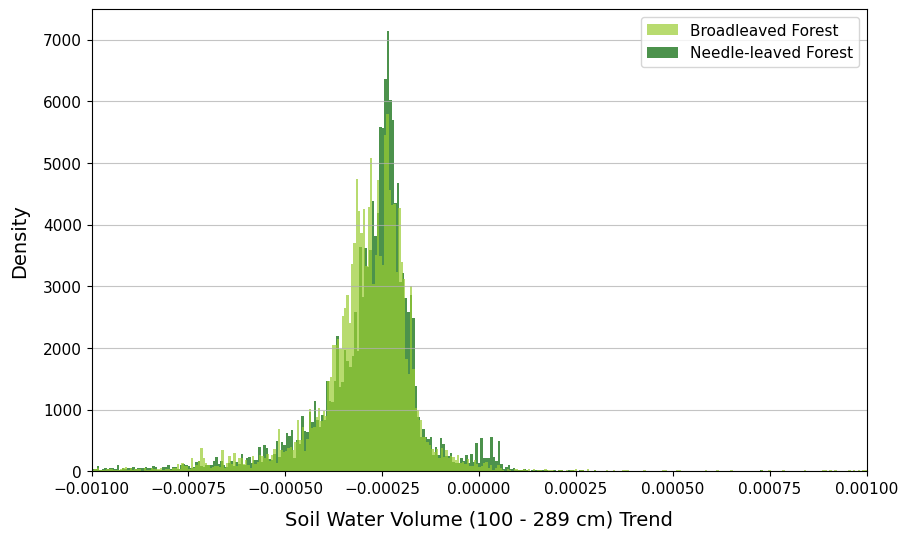

In [45]:
# plot histograms to look at distribution of values

BL_vals = swvl4_BL.variables['swvl4'][:,:].values
NL_vals = swvl4_NL.variables['swvl4'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Water Volume (100 - 289 cm) Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_4_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [46]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc:.{10}f}")
print(f"Calculated 98th Percentile: {vmax_perc:.{10}f}")

Calculated 2nd Percentile: -0.0010812940
Calculated 98th Percentile: 0.0000740151


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\1702635733.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


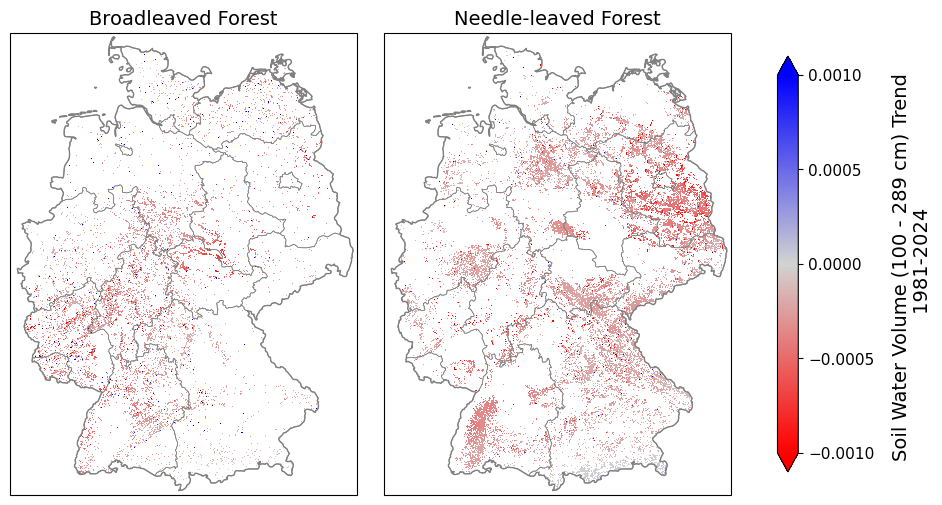

In [64]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl4_BL.variables['swvl4'][:,:]
NL = swvl4_NL.variables['swvl4'][:,:]
lats = swvl4_BL.variables['lat'][:]
lons = swvl4_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.001
vmax = 0.001

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil Water Volume (100 - 289 cm) Trend \n 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_4_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### SPEI Trend Germany

In [48]:
spei = xr.open_dataset("./Spatial_Trends/SPEI_Spatial_Trend_GER.nc")

In [49]:
spei_vals = spei.variables['SPEI'][:,:].values

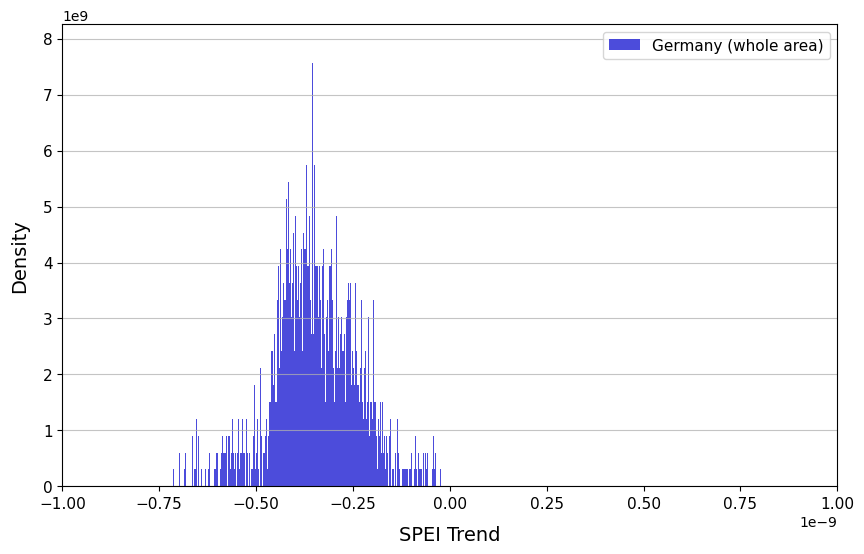

In [50]:
# plot histogram to look at distribution of values
plt.figure(figsize=(10, 6))

plt.hist(spei_vals.flatten(), bins=1000, alpha=0.7, label='Germany (whole area)', color='mediumblue', density=True) 

# add labels
plt.xlabel('SPEI Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

plt.legend(loc = 1, fontsize = 11)
plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.000000001, 0.000000001) 

plt.savefig("./Figures/SPEI_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [51]:
# have a look at the percentiles
data = spei_vals.flatten()

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(data[~np.isnan(data)], lower_percentile)
vmax_perc = np.percentile(data[~np.isnan(data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc:.{11}f}")
print(f"Calculated 98th Percentile: {vmax_perc:.{11}f}")

Calculated 2nd Percentile: -0.00000000060
Calculated 98th Percentile: -0.00000000013


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\3820873717.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


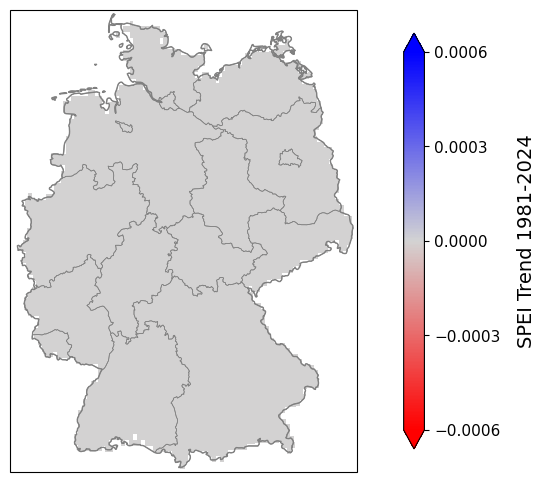

In [52]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variable from xarray
spei_var = spei.variables['SPEI'][:,:]
lats = spei.variables['lat'][:]
lons = spei.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0006
vmax = 0.0006

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})

ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

# plot data
im = ax.pcolormesh(
        lons, lats, spei_var,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto")

# plot borders
ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("SPEI Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/SPEI_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### NIRv GPP Trend

In [53]:
gpp_BL = xr.open_dataset("./Spatial_Trends/GPP_Spatial_Trend_BL.nc")
gpp_NL = xr.open_dataset("./Spatial_Trends/GPP_Spatial_Trend_NL.nc")

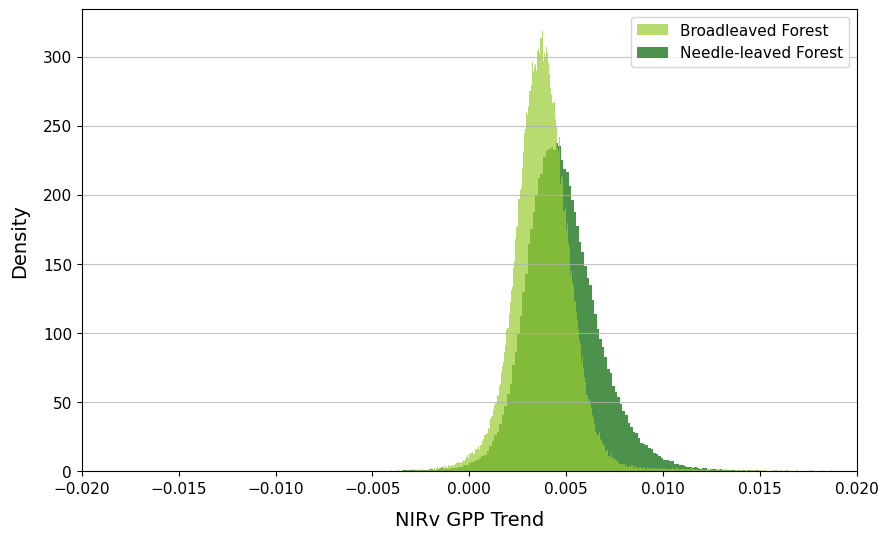

In [54]:
# plot histograms to look at distribution of values

BL_vals = gpp_BL.variables['GPP'][:,:].values
NL_vals = gpp_NL.variables['GPP'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('NIRv GPP Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.02, 0.02) 

plt.savefig("./Figures/GPP_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [55]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc:.{10}f}")
print(f"Calculated 98th Percentile: {vmax_perc:.{10}f}")

Calculated 2nd Percentile: 0.0008357230
Calculated 98th Percentile: 0.0094626653


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\3955606813.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


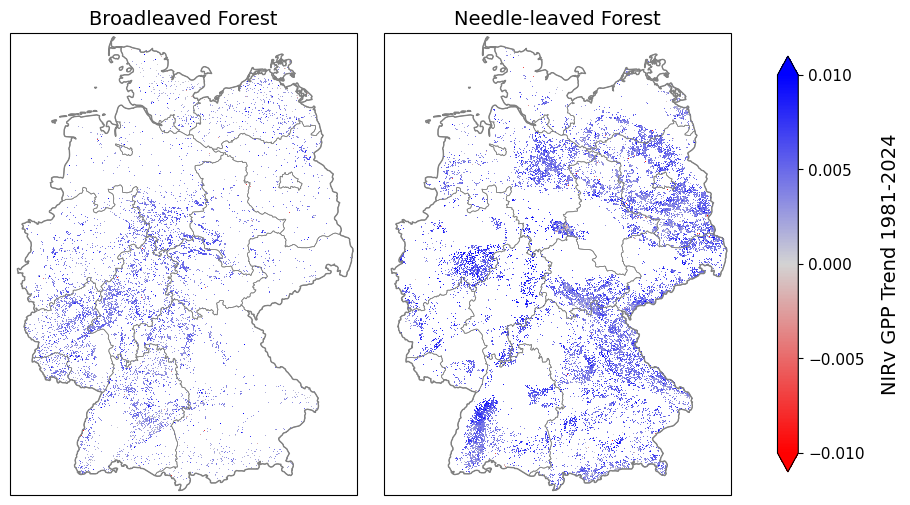

In [56]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = gpp_BL.variables['GPP'][:,:]
NL = gpp_NL.variables['GPP'][:,:]
lats = gpp_BL.variables['lat'][:]
lons = gpp_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.01
vmax = 0.01

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NIRv GPP Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/GPP_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### NPP Trend

In [57]:
npp_BL = xr.open_dataset("./Spatial_Trends/NPP_Spatial_Trend_BL.nc")
npp_NL = xr.open_dataset("./Spatial_Trends/NPP_Spatial_Trend_NL.nc")

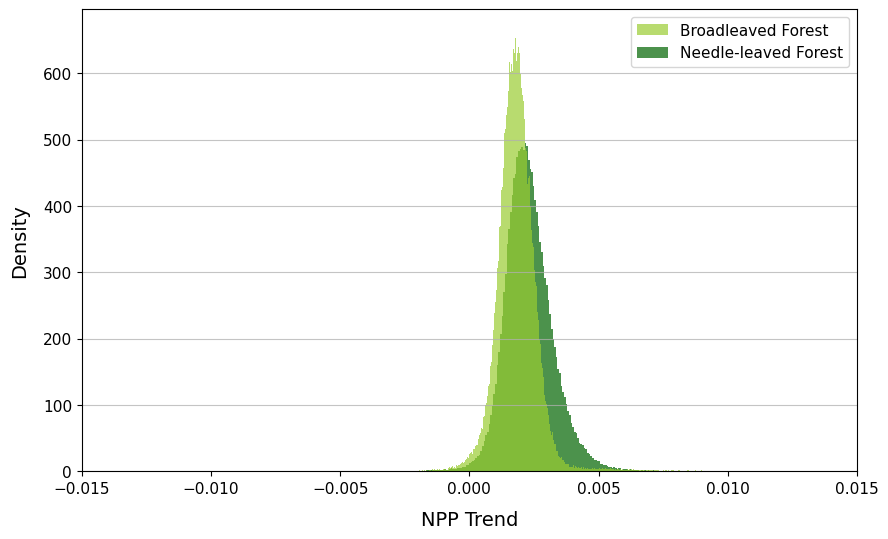

In [58]:
# plot histograms to look at distribution of values

BL_vals = npp_BL.variables['NPP'][:,:].values
NL_vals = npp_NL.variables['NPP'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('NPP Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.015, 0.015) 

plt.savefig("./Figures/NPP_Spatial_Trend_Histogram.png", bbox_inches="tight")
plt.show()

In [59]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 2 
upper_percentile = 98 

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 2nd Percentile: {vmin_perc:.{10}f}")
print(f"Calculated 98th Percentile: {vmax_perc:.{10}f}")

Calculated 2nd Percentile: 0.0004011470
Calculated 98th Percentile: 0.0045420793


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\1257521458.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


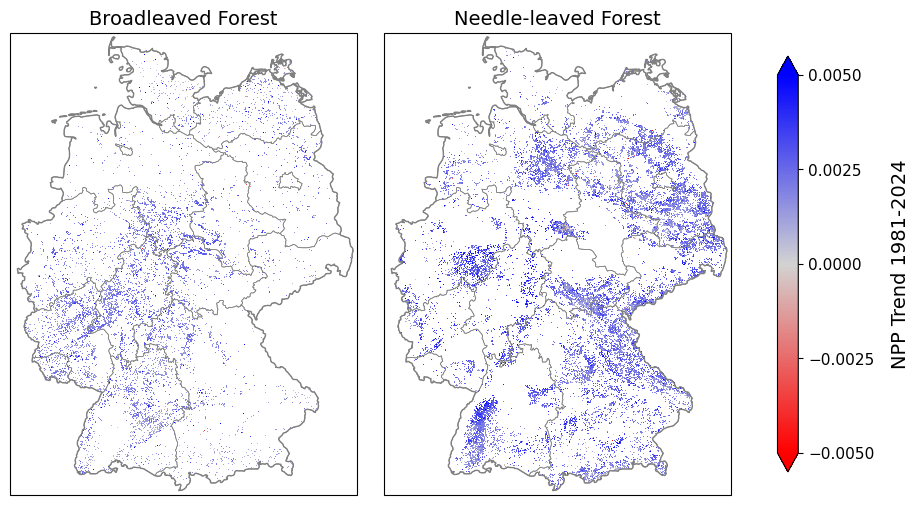

In [60]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = npp_BL.variables['NPP'][:,:]
NL = npp_NL.variables['NPP'][:,:]
lats = npp_BL.variables['lat'][:]
lons = npp_BL.variables['lon'][:]

# create custom colormap
colors = ["red", "lightgrey", "blue"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.005
vmax = 0.005

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved Forest', 'Needle-leaved Forest']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NPP Trend 1981-2024", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/NPP_Spatial_Trend.png", bbox_inches="tight")
plt.show()